# Vorbereitung

## Dependencies

In [29]:
from tensorflow import keras
import tensorflow.keras.backend as K
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


## Datensätze

### Künstlichen Datensatz erzeugen

In [30]:
def target_variable(x):
    return (1/2)*x[0] - (1/4)*(x[1]**2) + (1/2)*abs(x[2])*math.sin(2*x[2]) + (1/2)*x[3]*x[4] + (1/8)*(x[4]**2)*x[5]

In [31]:
# Random Number Generator
rng = np.random.default_rng(seed=0)

# Trainingsdatensatz
## Generate Training Data x1, x3, x4, x5, x6, x7
x1_train = rng.standard_normal(size=(100000,1))
x3_7_train = rng.standard_normal(size=(100000, 5))

## Variablen x2, x8 mit 50 % Korrelation
cov_matrix = [[1, 0.5], [0.5, 1]]
x2_x8_train = rng.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=100000)

# Zusammenfügen und Zielvariable berechnen
x_train = np.column_stack(
    (x1_train, x2_x8_train[:, 0], x3_7_train, x2_x8_train[:, 1]))
y_train = np.array(list(map(target_variable, x_train[:, 0:7])))


In [32]:
# Testdatensatz
## Generate Training Data x1, x3, x4, x5, x6, x7
x1_test = rng.standard_normal(size=(100000, 1))
x3_7_test = rng.standard_normal(size=(100000, 5))

## Variablen x2, x8 mit 50 % Korrelation
x2_x8_test = rng.multivariate_normal(mean=[0, 0], cov=cov_matrix, size=100000)

# Zusammenfügen und Zielvariable berechnen
x_test = np.column_stack(
    (x1_test, x2_x8_test[:, 0], x3_7_test, x2_x8_test[:, 1]))
y_test = np.array(list(map(target_variable, x_test[:, 0:7])))

In [33]:
# Check, if x2 and x8 are correlated
np.cov(x_train[:,1],x_train[:,7])

array([[0.99728065, 0.49687875],
       [0.49687875, 0.99504566]])

### Realer Datensatz

In [34]:
# french motor third party liability dataset
mtpl_df = pd.read_csv("/Users/philippknoop/Desktop/pyLocalGLMnet/data/freMTPL2freq.csv")


In [35]:
mtpl_df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


# LocalGLMnet

## Model trainieren

In [36]:
input = keras.Input(shape=(8), dtype= "float32")

In [37]:
attention = input

attention = keras.layers.Dense(units=20, activation="tanh")(attention)
attention = keras.layers.Dense(units=15, activation="tanh")(attention)
attention = keras.layers.Dense(units=10, activation="tanh")(attention)
attention = keras.layers.Dense(units=8, activation="linear", name="Attention")(attention)

In [38]:
response = keras.layers.Dot(axes=1)([input, attention])
response = keras.layers.Dense(units=1, activation="linear", name="Response")(response) 
# Wofür Dense Schicht notwendig? Ggf. um einen letzten Bias in die Funktion einzufügen
# Wenn es bspw. 8 Inputvariablen gibt und das Modell vorher die Koeffizienten a1-a8 lernt kann das Modell so zusätzlich den Intercept a0 erlernen
# Dot Layer implementiert also die eigentliche Skip Connection --> Skalarprodukt multipliziert jeweils die Einträge mit dem selben Index verschiedener Ebenen und addiert diese
# Da im Skalarprodukt der Einfluss jeder Variable enthalten ist muss um Aussage über die Feature Contribution einzelner Werte machen zu könnnen die partielle Ableitung 
# nach der entsprechenden Variable genommen werden

In [39]:
model = keras.Model(inputs=input, outputs=response)
model.compile(loss="mse", optimizer="nadam")

In [40]:
history = model.fit(x_train, y_train,
          batch_size=32, epochs=10)

Epoch 1/10
3125/3125 [==============================] - 3s 778us/step - loss: 0.1740
Epoch 2/10
3125/3125 [==============================] - 2s 792us/step - loss: 0.0386
Epoch 3/10
3125/3125 [==============================] - 2s 777us/step - loss: 0.0244
Epoch 4/10
3125/3125 [==============================] - 2s 777us/step - loss: 0.0119
Epoch 5/10
3125/3125 [==============================] - 2s 779us/step - loss: 0.0061
Epoch 6/10
3125/3125 [==============================] - 3s 805us/step - loss: 0.0046
Epoch 7/10
3125/3125 [==============================] - 2s 780us/step - loss: 0.0041
Epoch 8/10
3125/3125 [==============================] - 2s 771us/step - loss: 0.0039
Epoch 9/10
3125/3125 [==============================] - 3s 804us/step - loss: 0.0038
Epoch 10/10
3125/3125 [==============================] - 2s 772us/step - loss: 0.0037


In [41]:
print(history.history)

{'loss': [0.17401336133480072, 0.03862573578953743, 0.024424687027931213, 0.011928468011319637, 0.006148388143628836, 0.0045727938413619995, 0.00409656809642911, 0.003915352746844292, 0.0038480565417557955, 0.0036856476217508316]}


## Regression Attention

In [42]:
# Über die Methode get_weights() erhält man die Kantengewichte, sowie den Bias für jeder Schicht
# --> man erhält also eine Liste mit numpy Arrays die in der Länge der Anzahl der Ebenen * 2

for i in model.get_weights():
    print(i.shape, end= " | ")

(8, 20) | (20,) | (20, 15) | (15,) | (15, 10) | (10,) | (10, 8) | (8,) | (1, 1) | (1,) | 

In [43]:
# Neues Model ohne Response-Schicht --> auslesen der Attention Schicht
weights_model = keras.Model(
    inputs=model.input, 
    outputs=model.get_layer(name="Attention").output)

# Gewichte bestimmen
beta_x = weights_model.predict(x_test)

In [44]:
# Skalierung der Attention mithilfe der Gewichte der Response Schicht (!= der tatsächlichen Vorhersage (--> beta_x liefert 8 Outputwerte, Response nur 1 Output))
beta_x = beta_x * model.get_weights()[8]

# our architecture still requires a scaling coming from dense layer ’Response’ which 
# we add to have intercept beta_0 in our LocalGLMnet architecture 
# beta.x <- beta.x * as.numeric(get_weights(model)[[9]])

# Ggf. in die Skalierung letzten Bias mit aufnehmen?
# --> beta_x = beta_x * model.get_weights()[8] + model.get_weights()[9]


## Plots

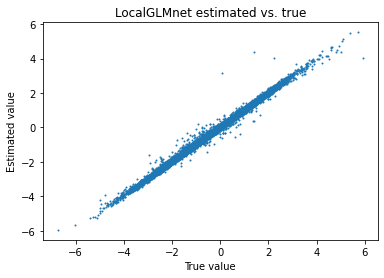

In [45]:
pred = model.predict(x_test)

plt.scatter(y_test, pred, s= 1)
plt.xlabel("True value")
plt.ylabel("Estimated value")
plt.title("LocalGLMnet estimated vs. true")
plt.show()

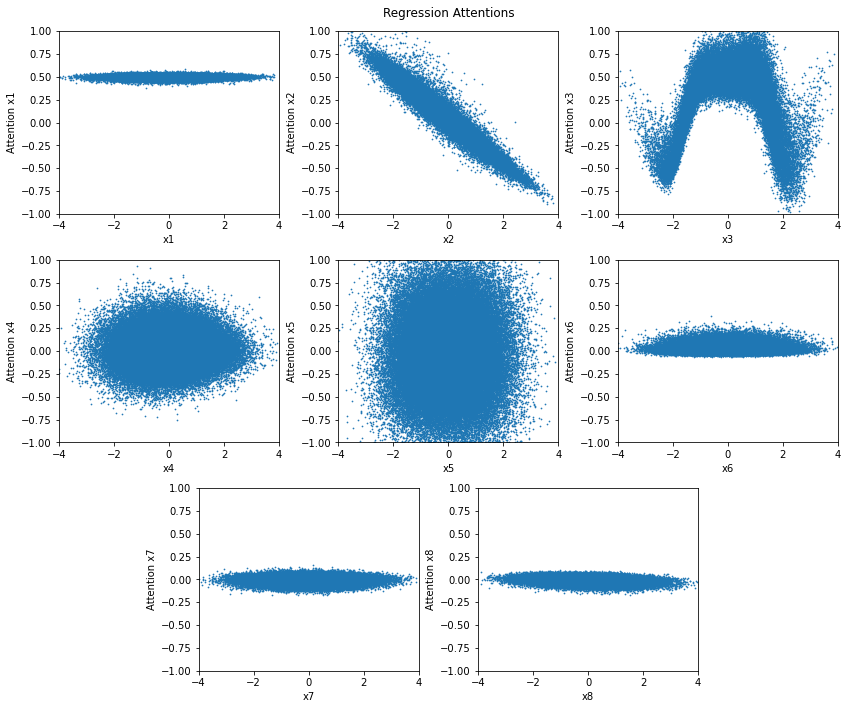

In [46]:
fig_attention = plt.figure(tight_layout=True, figsize=(15,10))

spec = GridSpec(ncols=8, nrows=3, figure=fig_attention)
ax1_att = fig_attention.add_subplot(spec[0, 1:3])
ax2_att = fig_attention.add_subplot(spec[0, 3:5])
ax3_att = fig_attention.add_subplot(spec[0, 5:7])
ax4_att = fig_attention.add_subplot(spec[1, 1:3])
ax5_att = fig_attention.add_subplot(spec[1, 3:5])
ax6_att = fig_attention.add_subplot(spec[1, 5:7])
ax7_att = fig_attention.add_subplot(spec[2, 2:4])
ax8_att = fig_attention.add_subplot(spec[2, 4:6])

axs = [ax1_att, ax2_att, ax3_att, ax4_att, ax5_att, ax6_att, ax7_att, ax8_att]

for i in range(len(axs)):
    axs[i].scatter(x_test[:, i],
                     beta_x[:, i], s=0.5)
    axs[i].set_xlim((-4, 4))
    axs[i].set_ylim((-1, 1))
    axs[i].set_xlabel('x'+str(i+1))
    axs[i].set_ylabel('Attention x'+str(i+1))

fig_attention.suptitle("Regression Attentions")
plt.show()


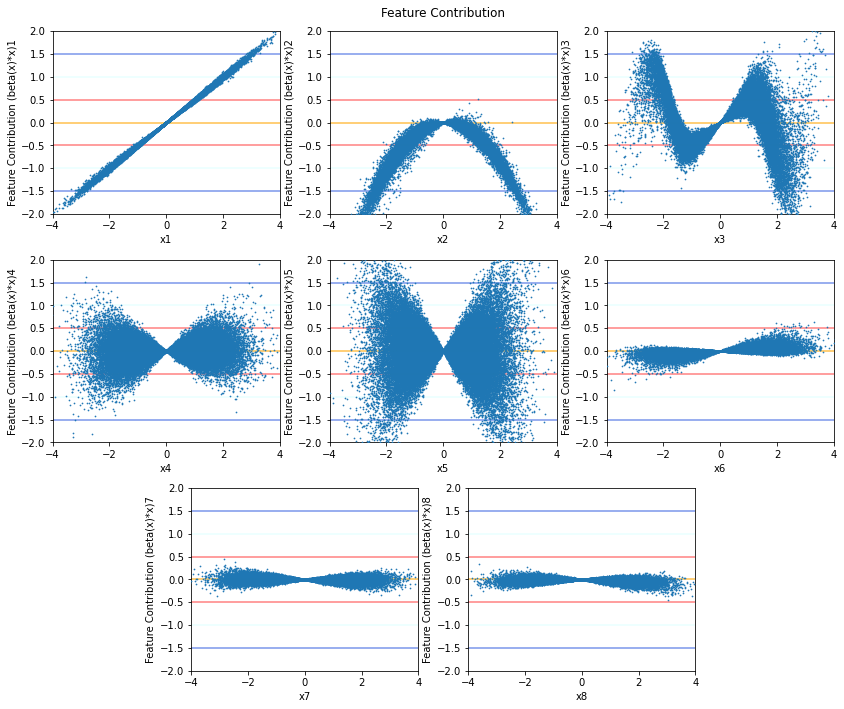

In [47]:
# Feature Contribution = beta(xi)*xi
fig_contribution = plt.figure(tight_layout=True, figsize=(15,10))

spec = GridSpec(ncols=8, nrows=3, figure=fig_attention)
ax1_con = fig_contribution.add_subplot(spec[0, 1:3])
ax2_con = fig_contribution.add_subplot(spec[0, 3:5])
ax3_con = fig_contribution.add_subplot(spec[0, 5:7])
ax4_con = fig_contribution.add_subplot(spec[1, 1:3])
ax5_con = fig_contribution.add_subplot(spec[1, 3:5])
ax6_con = fig_contribution.add_subplot(spec[1, 5:7])
ax7_con = fig_contribution.add_subplot(spec[2, 2:4])
ax8_con = fig_contribution.add_subplot(spec[2, 4:6])

axs = [ax1_con, ax2_con, ax3_con, ax4_con, ax5_con, ax6_con, ax7_con, ax8_con]

for i in range(len(axs)):
    
    # Hinzufügen von horizontalen Linien um die Stärke der Feature Contribution zu visualisieren
    # Alpha --> Opacity
    # zorder --> horizontale Linien im Hintergrund/hinter eigentlichem Plot
    axs[i].hlines(y=0,xmin=-4,xmax=4, colors="orange",alpha=0.7,zorder=1)

    axs[i].hlines(y=0.5,xmin=-4,xmax=4, colors="red",alpha=0.5,zorder=1)
    axs[i].hlines(y=-0.5,xmin=-4,xmax=4, colors="red",alpha=0.5,zorder=1)

    axs[i].hlines(y=1,xmin=-4,xmax=4, colors="lightcyan",alpha=0.7,zorder=1)
    axs[i].hlines(y=-1,xmin=-4,xmax=4, colors="lightcyan",alpha=0.7,zorder=1)

    axs[i].hlines(y=1.5,xmin=-4,xmax=4, colors="royalblue",alpha=0.7,zorder=1)
    axs[i].hlines(y=-1.5,xmin=-4,xmax=4, colors="royalblue",alpha=0.7,zorder=1)

    # Scatter Plot --> x: Werte der Inputfeatures, y:Feature Contribution (β(x)*x)
    axs[i].scatter(x_test[:, i],
                     beta_x[:, i]*x_test[:, i], s=0.5,zorder=10)

    axs[i].set_xlim((-4, 4))
    axs[i].set_ylim((-2, 2))
    axs[i].set_xlabel('x'+str(i+1))
    axs[i].set_ylabel('Feature Contribution (beta(x)*x)'+str(i+1))

fig_contribution.suptitle("Feature Contribution")
plt.show()

### Spline Fits

In [102]:
beta_0 = attention
beta_0 = keras.layers.Lambda(lambda x: x[:,0])(beta_0)
model_0 = keras.Model(inputs = input, outputs = beta_0)

In [78]:
model_0.outputs

[<KerasTensor: shape=(None,) dtype=float32 (created by layer 'lambda_10')>]

In [79]:
model_0.inputs

[<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'input_2')>]

In [98]:
beta_0

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'lambda_10')>

In [89]:
grad_0 = beta_0
grad_0 = keras.layers.Lambda(lambda x: K.gradients(loss= model_0.outputs, variables=model_0.inputs))(grad_0)

TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.

In [ ]:
for i in model_0.get_weights():
    print(i.shape, end= " | ")

In [ ]:
model_0.inputs

In [ ]:

grad = beta_0
grad = keras.layers.Lambda(lambda x: K.gradients(model_0.outputs, model_0.inputs))(grad)
model_grad = keras.Model(inputs = input, outputs = grad)

grad_beta = model_grad.predict(x=x_test)
 

In [96]:
model_0.output

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'lambda_10')>